In [1]:
!pip install ale_py > /dev/null 2>&1
!pip install gymnasium[accept-rom-license,atari]==1.0.0 > /dev/null 2>&1

# 测试

In [2]:
%%writefile easy_helper.py
class algo_base:
    def __init__(self, **kwargs):
        self._training_kwargs = kwargs

    @property
    def training_kwargs(self):
        return self._training_kwargs
    
    def _update_kwargs(self, kwargs):
        for k, v in kwargs.items():
            self._training_kwargs[k] = v

class PPO(algo_base):
    @property
    def algo(self):
        return "PPO"

class IMPALA(algo_base):
    @property
    def algo(self):
        return "IMPALA"

class APPO(algo_base):
    def __init__(self, **kwargs):
        self._training_kwargs = {
            'grad_clip': 30.0,
        }

        self._update_kwargs(kwargs)

    @property
    def algo(self):
        return "APPO"

class DQN(algo_base):

    @property
    def algo(self):
        return "DQN"
    
class Rainbow_DQN(DQN):
    def __init__(self, **kwargs):
        self._training_kwargs = {
            "target_network_update_freq": 500,
            'replay_buffer_config': {
                "type": "PrioritizedEpisodeReplayBuffer",
                "capacity": 60000,
                "alpha": 0.5,
                "beta": 0.5,
            },
            # "replay_buffer_config": {
            #     "_enable_replay_buffer_api": False,
            #     "type": "ReplayBuffer",
            #     "type": "PrioritizedReplayBuffer",
            #     "capacity": 50000,
            #     "prioritized_replay_alpha": 0.6,
            #     "prioritized_replay_beta": 0.4,
            #     "prioritized_replay_eps": 1e-6,
            #     "replay_sequence_length": 1
            # },
            "epsilon": [[0, 1.0], [1000000, 0.1]],
            "adam_epsilon": 1e-8,
            "grad_clip": 40.0,
            "num_steps_sampled_before_learning_starts": 10000,
            "tau": 1,
            "num_atoms": 51,
            "v_min": -10.0,
            "v_max": 10.0,
            "noisy": True,
            "sigma0": 0.5,
            "dueling": True,
            "hiddens": [512],
            "double_q": True,
            "n_step": 3,
        }

        self._update_kwargs(kwargs)

class Double_DQN(DQN):
    def __init__(self, **kwargs):
        self._training_kwargs = {
            'double_q': True,
        }

        self._update_kwargs(kwargs)

class Dueling_DQN(DQN):
    def __init__(self, **kwargs):
        self._training_kwargs = {
            'dueling': True,
        }

        self._update_kwargs(kwargs)

class DQN_PER(DQN):
    def __init__(self, **kwargs):
        self._training_kwargs = {
            'replay_buffer_config': {
                "type": "PrioritizedEpisodeReplayBuffer",
                "capacity": 60000,
                "alpha": 0.5,
                "beta": 0.5,
            },
        }

        self._update_kwargs(kwargs)

class Noisy_DQN(DQN):
    def __init__(self, **kwargs):
        self._training_kwargs = {
            'noisy': True,
        }
        
        self._update_kwargs(kwargs)

class DQN_C51(DQN):
    def __init__(self, **kwargs):
        self._training_kwargs = {
            'num_atoms': 51,
            'v_min': -10.0,
            'v_max': 10.0,
        }
        
        self._update_kwargs(kwargs)

def simplify_rllib_metrics(data, out_func=print):
    important_metrics = {
        "环境运行器": {},
        "评估": {},
        "学习者": {},
    }

    if 'counters' in data:
        if 'num_env_steps_sampled' in data["counters"]:
            important_metrics["环境运行器"]["采样环境总步数"] = data["counters"]["num_env_steps_sampled"]

    if 'env_runners' in data:
        if 'episode_return_mean' in data["env_runners"]:
            important_metrics["环境运行器"]["episode平均回报"] = data["env_runners"]["episode_return_mean"]
        if 'episode_return_max' in data["env_runners"]:
            important_metrics["环境运行器"]["episode最大回报"] = data["env_runners"]["episode_return_max"]
        if 'episode_len_mean' in data["env_runners"]:
            important_metrics["环境运行器"]["episode平均步数"] = data["env_runners"]["episode_len_mean"]
        if 'episode_len_max' in data["env_runners"]:
            important_metrics["环境运行器"]["episode最大步数"] = data["env_runners"]["episode_len_max"]
        if 'num_env_steps_sampled' in data["env_runners"]:
            important_metrics["环境运行器"]["采样环境总步数"] = data["env_runners"]["num_env_steps_sampled"]
        if 'num_episodes' in data["env_runners"]:
            important_metrics["环境运行器"]["episodes计数"] = data["env_runners"]["num_episodes"]

    if 'evaluation' in data:
        if 'env_runners' in data["evaluation"]:
            if 'episode_return_mean' in data["evaluation"]["env_runners"]:
                important_metrics["评估"]["episode平均回报"] = data["evaluation"]["env_runners"]["episode_return_mean"]
            if 'episode_return_max' in data["evaluation"]["env_runners"]:
                important_metrics["评估"]["episode最大回报"] = data["evaluation"]["env_runners"]["episode_return_max"]
            if 'episode_len_mean' in data["evaluation"]["env_runners"]:
                important_metrics["评估"]["episode平均步数"] = data["evaluation"]["env_runners"]["episode_len_mean"]
            if 'episode_len_max' in data["evaluation"]["env_runners"]:
                important_metrics["评估"]["episode最大步数"] = data["evaluation"]["env_runners"]["episode_len_max"]

    if 'learners' in data:
        if 'default_policy' in data["learners"]:
            important_metrics["学习者"]["默认策略"] = {}
            if 'entropy' in data["learners"]["default_policy"]:
                important_metrics["学习者"]["默认策略"]["熵"] = data["learners"]["default_policy"]["entropy"]
            if 'policy_loss' in data["learners"]["default_policy"]:
                important_metrics["学习者"]["默认策略"]["策略损失"] = data["learners"]["default_policy"]["policy_loss"]
            if 'vf_loss' in data["learners"]["default_policy"]:
                important_metrics["学习者"]["默认策略"]["值函数损失"] = data["learners"]["default_policy"]["vf_loss"]
            if 'total_loss' in data["learners"]["default_policy"]:
                important_metrics["学习者"]["默认策略"]["总损失"] = data["learners"]["default_policy"]["total_loss"]

    if 'time_this_iter_s' in data:
        important_metrics["本轮时间"] = data["time_this_iter_s"]
    if 'num_training_step_calls_per_iteration' in data:
        important_metrics["每轮训练步数"] = data["num_training_step_calls_per_iteration"]
    if 'training_iteration' in data:
        important_metrics["训练迭代次数"] = data["training_iteration"]
            
    out_func(f"--------- 训练迭代: {important_metrics['训练迭代次数']} ---------")
    out_func("环境运行器:")
    if important_metrics['环境运行器']:
        for k, v in important_metrics['环境运行器'].items():
            out_func(f"  {k}: {v:.4f}")
    else:
        out_func("  无环境运行器数据")
    
    out_func("\n评估:")
    for k, v in important_metrics['评估'].items():
        out_func(f"  {k}: {v:.4f}")
    else:
        out_func("  无评估数据")

    out_func("\n学习者(默认策略):")
    if '默认策略' in important_metrics['学习者'] and important_metrics['学习者']['默认策略']:
        for k, v in important_metrics['学习者']['默认策略'].items():
            out_func(f"  {k}: {v:.4f}")
    else:
        out_func("  无学习者数据")
    
    if '本轮时间' in important_metrics:
        out_func(f"\n本轮时间: {important_metrics['本轮时间']:.4f}")
    if '每轮训练步数' in important_metrics:
        out_func(f"每轮训练步数: {important_metrics['每轮训练步数']}")
    out_func('-'*30)

    return important_metrics


Writing easy_helper.py


In [3]:
%%writefile compress.py
import math
import torch
from typing import List, Tuple, Dict

class DeepGradientCompression:
    def __init__(self, momentum_buffer_size=32, compress_ratio=0.02, 
                 communication_threshold=0.001,
                 momentum_factor=0.9):

        """
        Args:
            momentum_buffer_size (int): 动量缓冲区大小
            compress_ratio (float): 压缩比率
            communication_threshold (float): 通信阈值
            momentum_factor (float): 动量因子
        """

        self.momentum_buffer_size = momentum_buffer_size
        self.compress_ratio = compress_ratio
        self.communication_threshold = communication_threshold
        self.momentum_factor = momentum_factor
        
        self.momentum_states = {}

        # 可压缩的最小元素数量，若小于这个数量的原始数据，取最大的一个梯度进行更新
        self.min_raw_elements = int(math.ceil(1 / compress_ratio))

    def clear(self):
        self.momentum_states = {}

    def compress_shape(self, original_shape):
        """计算压缩后的形状, 确保压缩后长度不为0

        compress_ratio = 0.02
        min_raw_elements = 50

        1. raw_elements = 49
            compressed_size = 1

        2. raw_elements = 50
            compressed_size = 1
        """
        raw_elements = math.prod(original_shape)
        if raw_elements < self.min_raw_elements:
            return (1, )
        compressed_size = int(math.prod(original_shape) * self.compress_ratio)
        return (compressed_size,)

    def compress(self, gradients, need_warm_up_steps=False):
        """压缩梯度，确保输出大小固定且不小于最小元素数量"""

        compressed_gradients = []
        compression_infos = []

        # 预热期间不压缩
        if need_warm_up_steps:
            for idx, gradient in enumerate(gradients):
                param_name = f'grad_{idx}'

                # 初始化动量状态
                if param_name not in self.momentum_states:
                    self.momentum_states[param_name] = torch.zeros_like(gradient)
                
                # 计算新的动量
                momentum_grad = (self.momentum_factor * self.momentum_states[param_name]) + gradient
                self.momentum_states[param_name] = momentum_grad
                
                compression_info = {
                    'is_full_gradient': True,
                }
                
                compressed_gradients.append(momentum_grad)
                compression_infos.append(compression_info)
            
        else:
            # 处理每个梯度
            for idx, gradient in enumerate(gradients):
                param_name = f'grad_{idx}'

                # 检查梯度 inf/nan
                if torch.isnan(gradient).any() or torch.isinf(gradient).any():
                    raise ValueError(f"梯度 {param_name} 包含 inf/nan 值")

                # 扁平化梯度
                flat_grad = gradient.view(-1)

                # 初始化动量状态
                if param_name not in self.momentum_states or self.momentum_states[param_name].shape != flat_grad.shape:
                    if param_name in self.momentum_states:
                        log(f"param {param_name} shape {self.momentum_states[param_name].shape} change to {flat_grad.shape}, most likely due to no more need warm up")
                    self.momentum_states[param_name] = torch.zeros_like(flat_grad)
                
                # 计算新的动量
                momentum_grad = (self.momentum_factor * self.momentum_states[param_name]) + flat_grad
                self.momentum_states[param_name] = momentum_grad
                
                # 计算阈值
                abs_grad = torch.abs(momentum_grad)
                threshold = max(
                    torch.quantile(abs_grad, 1 - self.compress_ratio), 
                    self.communication_threshold
                )
            
                # 获取重要梯度的掩码和索引
                important_mask = abs_grad >= threshold
                important_indices = torch.nonzero(important_mask).squeeze()

                # 校正索引
                compressed_size = self.compress_shape(gradient.shape)[0]

                if important_indices.numel() < compressed_size:
                    # 没有重要梯度 / 重要梯度数量不足
                    # 选取 topk k = compressed_size
                    topk = torch.topk(abs_grad, compressed_size)
                    important_indices = topk.indices

                elif important_indices.numel() > compressed_size:
                    # 随机抽取降采样
                    important_indices = important_indices[torch.randperm(len(important_indices))[:compressed_size]]

                # 获取重要梯度
                important_grad = momentum_grad[important_indices]
                
                compression_info = {
                    'indices': important_indices,
                    'is_full_gradient': False,
                    'original_shape': gradient.shape
                }
                
                compressed_gradients.append(important_grad)
                compression_infos.append(compression_info)

        return compressed_gradients, compression_infos

    def decompress(self, compressed_grads, compression_infos):
        decompressed_gradients = []

        for compressed_grad, comp_info in zip(compressed_grads, compression_infos):
            # 如果是全梯度,不需要解压
            if comp_info['is_full_gradient']:
                decompressed_gradients.append(compressed_grad)
                continue

            # 创建零张量
            full_gradient = torch.zeros(
                math.prod(comp_info['original_shape']), 
                device=compressed_grad.device
            )
            
            # 填充压缩后的梯度
            full_gradient[comp_info['indices']] = compressed_grad
            
            # 恢复原始形状
            decompressed_gradients.append(full_gradient.view(comp_info['original_shape']))
        
        return decompressed_gradients

CompressInfo = Dict[str, List[torch.Tensor]]

class IncrementalCompressor:
    def __init__(self, 
                 threshold: float = 1e-3,
                 sparsity_threshold: float = 0.3  # 稀疏度阈值，超过则全量更新
                ):
        """
        参数:
            threshold: 压缩阈值,只压缩变化大于此值的参数
            sparsity_threshold: 稀疏度阈值，当更新元素比例超过此值时切换为全量更新
        """
        self.threshold = threshold
        self.sparsity_threshold = sparsity_threshold
        self.client_params = {}  # 存储不同客户端的参数 {client_id: List[tensor]}
        
    def _init_reference(self, 
                       client_id: str,
                       tensors: List[torch.Tensor],
                      ) -> None:
        """初始化参考张量"""
        if client_id not in self.client_params:
            self.client_params[client_id] = [t.clone().detach() for t in tensors]
            return True
        
    def compress(self, 
                tensors: List[torch.Tensor],
                client_id: str,
               ) -> Tuple[List[torch.Tensor], CompressInfo]:
        """压缩张量列表"""
        init = self._init_reference(client_id, tensors)
        if init:
            return tensors, {'full': True}
        
        compressed_tensors = []
        compress_info = {
            'update_indices': [],
            'full': []
        }
        
        for curr_t, last_t in zip(tensors, self.client_params[client_id]):
            # 计算变化量
            diff = torch.abs(curr_t - last_t)
            mask = diff > self.threshold
            
            # 计算更新比例
            update_ratio = mask.sum().item() / mask.numel()
            
            # 根据更新比例决定使用全量更新还是增量更新
            if update_ratio > self.sparsity_threshold:
                # 全量更新
                compressed_tensors.append(curr_t)
                compress_info['full'].append(True)
                compress_info['update_indices'].append(None)
                last_t[:] = curr_t[:]
            else:
                # 增量更新
                update_indices = torch.where(mask)
                update_values = curr_t[mask]
                
                compressed_tensors.append(update_values)
                compress_info['update_indices'].append(torch.stack(update_indices, dim=1))
                compress_info['full'].append(False)
                
                # 更新参考张量
                last_t[mask] = curr_t[mask]
            
        return compressed_tensors, compress_info
    
    @staticmethod
    def decompress(
                  compressed_tensors: List[torch.Tensor],
                  compress_info: CompressInfo,
                  param_dict: Dict[str, torch.Tensor]
                ) -> None:
        """解压张量列表并直接更新参数字典"""
        param_names = list(param_dict.keys())
        
        if isinstance(compress_info.get('full'), bool):
            # 全部全量更新
            for param_name, compressed_t in zip(param_names, compressed_tensors):
                param_dict[param_name][:] = compressed_t[:]
            return
            
        # 混合更新模式
        for param_name, compressed_t, is_full, indices in zip(
            param_names,
            compressed_tensors,
            compress_info['full'],
            compress_info['update_indices']
        ):
            if is_full:
                # 全量更新
                param_dict[param_name][:] = compressed_t[:]
            else:
                # 增量更新
                if indices.numel() > 0:
                    param_dict[param_name][tuple(indices[:, i] for i in range(indices.shape[1]))] = compressed_t

Writing compress.py


In [4]:
from ray.rllib.algorithms.ppo import PPOConfig
import sys
# sys.path.append(r"..")
from easy_helper import simplify_rllib_metrics
from compress import DeepGradientCompression, IncrementalCompressor
from ray.rllib.algorithms.ppo.torch.ppo_torch_learner import PPOTorchLearner
from ray.rllib.core import COMPONENT_RL_MODULE
import copy
import gymnasium as gym
import pandas as pd
import time, pickle
from collections import OrderedDict
from tqdm import tqdm

2025-02-16 23:53:47,344	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.


# 参数设置

In [5]:
allow_delay = 4# 每4个minibatch需要强制同步最新参数
params_compress = True# 是否压缩参数
grad_compress = True# 是否压缩梯度

# 模拟参数服务器训练(3个训练客户端)

In [6]:
server = None
pc = None
gc = None
# 0 value， 1 count
p_compress_ratio_list = [0, 0]
g_compress_ratio_list = [0, 0]
cur_client_id = [0]

if grad_compress:
    gc = DeepGradientCompression()

if params_compress:
    pc = IncrementalCompressor()

def get_weights(learner):
    return learner.get_state(components=COMPONENT_RL_MODULE)['rl_module']['default_policy']

def apply_gradients(gradients_list, learner):
    """更新参数"""
    # 解压梯度
    if grad_compress:
        gradients_list, compress_info = gradients_list
        gradients_list = gc.decompress(gradients_list, compress_info)

    # 应用梯度
    params = learner._params
    for k, v in zip(list(params.keys()), gradients_list):
        params[k].grad = v.to(learner._device)
    learner.apply_gradients({})

    # 压缩参数
    if params_compress:
        weights = learner.module._rl_modules['default_policy'].state_dict()
        size_0 = len(pickle.dumps(weights))
        weights = list(weights.values())
        weights = pc.compress(weights, cur_client_id[0])
        size_1 = len(pickle.dumps(weights))
        r = ((1 - size_1 / size_0) * 100)
        p_compress_ratio_list[1] += 1
        p_compress_ratio_list[0] += r
        # print(f"压缩率: {((1 - size_1 / size_0) * 100):.2f}%")
    else:
        weights = get_weights(learner)
    
    return weights

class DebugLearner(PPOTorchLearner):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.server_weights = None
        self.sync_weights = None
        self.count = 0

    def apply_gradients(self, gradients_dict) -> None:
        # 无用更新，最终参数也会被覆盖，可以优化
        # 客户端只需要计算梯度，不需要更新参数
        # super().apply_gradients(gradients_dict)

        # 每 allow_delay 个minibatch同步一次参数
        self.count += 1
        if allow_delay<=1 or self.count % allow_delay == 0:
            # 解压参数
            if params_compress:
                compressed_list, info_list = self.server_weights
                if None is self.sync_weights:
                    self.sync_weights = self.module._rl_modules['default_policy'].state_dict()
                pc.decompress(compressed_list, info_list, self.sync_weights)
                self.module._rl_modules['default_policy'].load_state_dict(self.sync_weights)
            else:
                self.set_state({'rl_module': {'default_policy': self.server_weights}})
    
    def compute_gradients(self, loss_per_module, **kwargs):
        gradients = super().compute_gradients(loss_per_module, **kwargs)

        # 统一成梯度列表
        gradients = [grad.to('cpu') for grad in gradients.values()]
        # 压缩梯度
        if grad_compress:
            size_0 = len(pickle.dumps(gradients))
            gradients = gc.compress(gradients)
            size_1 = len(pickle.dumps(gradients))
            r = ((1 - size_1 / size_0) * 100)
            g_compress_ratio_list[1] += 1
            g_compress_ratio_list[0] += r
            # print(f"压缩率: {((1 - size_1 / size_0) * 100):.2f}%")

        # 1. 梯度传递给参数服务器, 获取服务器参数
        self.server_weights = apply_gradients(gradients, server)

        return {}

server_config = (
    PPOConfig()
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .env_runners(num_env_runners=0)
)

client_config = (
    PPOConfig()
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .environment("CartPole-v1")
    .env_runners(num_env_runners=0)
    .training(
        learner_class=DebugLearner,# 调试学习者
    )
)

# 多次取平均
all_mean_returns = []
for j in range(10):
    # 初始化 参数服务器
    server = server_config.build_learner(env=gym.make("CartPole-v1"))
    server.build()

    # 初始化 客户端
    clients = []
    for i in range(3):
        clients.append(client_config.build())

    # 同步服务器参数 > 客户端
    server_init_params = get_weights(server)
    server_init_params = {'default_policy': server_init_params}
    for client in clients:
        client.learner_group.set_weights(server_init_params)

    mean_returns = []
    for i in tqdm(range(30), desc=f"[{j}]"):
        for idx, client in enumerate(clients):
            cur_client_id[0] = idx
            res = client.train()
            if idx == 0:
                result = simplify_rllib_metrics(res, out_func=lambda x: None)
                mean_returns.append(result["环境运行器"]["episode平均回报"])

    all_mean_returns.append(mean_returns)

2025-02-16 23:54:16,034	WARNING rl_module.py:419 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. All algos use the new stack by default. Ignore this message, if your RLModule does not use a Catalog to build its sub-components.
2025-02-16 23:54:16,035	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
2025-02-16 23:54:19,634	WARNING deprecation.py:50 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
2025-02-16 23:54:19,643	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! 

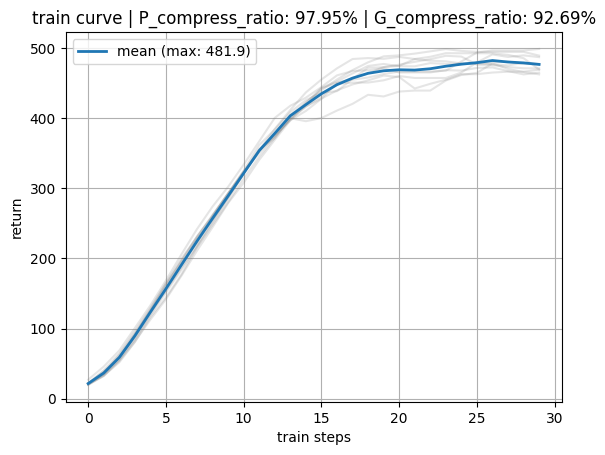

In [7]:
# 可视化
data = pd.DataFrame()
for idx, _data in enumerate(all_mean_returns):
    data[f"轮次{idx}"] = _data

data['mean'] = data.mean(axis=1)

import matplotlib.pyplot as plt
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 绘制所有轮次的曲线(淡显)
for col in data.columns:
    if col != 'mean':
        plt.plot(data[col], alpha=0.2, color='gray')

# 绘制平均值曲线(实线)        
max_val = data['mean'].max()
plt.plot(data['mean'], linewidth=2, label=f'mean (max: {max_val:.1f})')

plt.xlabel('train steps')
plt.ylabel('return')
plt.title(f'train curve | P_compress_ratio: {(p_compress_ratio_list[0] / p_compress_ratio_list[1]):.2f}% | G_compress_ratio: {(g_compress_ratio_list[0] / g_compress_ratio_list[1]):.2f}%')
plt.legend()
plt.grid(True)
plt.show()